## A Bayesian regularized artificial neural network for stock market forecasting

### Setup

In [1]:
from lib.dataset import Data, unscale_tensor

from lib.model.optimize import run_one_epoch 
from lib.model.utils import reset_all_weights, generate_bnn_summary
from lib.model.loss import WeightedLoss, mape_loss
from lib.model.plot import training_plot_summary

from lib.backtest import create_backtest_dataset, backtest_plot

In [2]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt 

import rich

In [3]:
import torch
import torch.nn as nn
import torchbnn

### Financial Data

In [4]:
ticker = "MSFT"

start_date = "2010-01-04"
end_date = "2012-12-31"
window_size = 30

train_prop = .8
ema_n_days = [5, 10] 
d_period = 3

data = Data(ticker, start_date, end_date, window_size, train_prop, ema_n_days, d_period)

[*********************100%***********************]  1 of 1 completed


c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [4]:
print(data)

Data(ticker='MSFT', start_date='2010-01-04', end_date='2012-12-31', batch_size=30, train_prop=0.8, ema_n_days=[5, 10], d_period=3, target_name='Close+1')


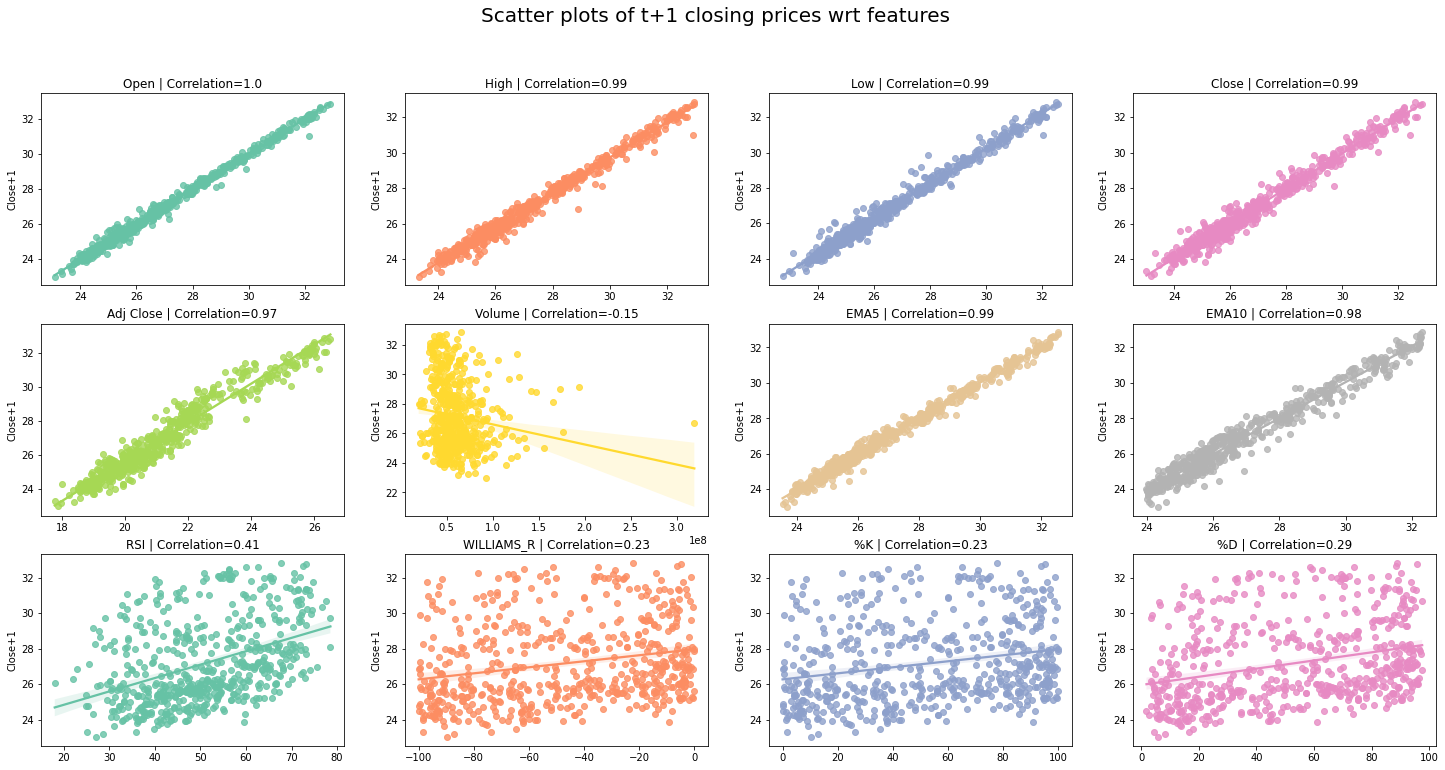

In [42]:
id_vars = data._df_train.columns.drop(labels="Close+1").tolist()
cor_mat = data._df_train.corr()["Close+1"]

ncols = 4
if len(id_vars) % ncols == 0: 
    nrows = len(id_vars) // ncols
else: 
    nrows = len(id_vars) // ncols + 1

colors = sns.color_palette("Set2", n_colors=len(id_vars)) 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 12))
fig.suptitle("Scatter plots of t+1 closing prices wrt features", size=20)

for var, ax, c in zip(id_vars, axes.flatten(), colors):
    sns.regplot(data=data._df_train, x=var, y="Close+1", color=c, ax=ax)
    ax.set_title(f"{var} | Correlation={round(cor_mat[var], 2)}")
    ax.set_xlabel("")

### Training & validation

**Bayesian MLP**

In [5]:
input_size = 9 
hidden_size = 5
output_size = 1

model = nn.Sequential(
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=input_size, out_features=hidden_size),
    nn.Tanh(),
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=hidden_size, out_features=output_size)
)

print(model)

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=9, out_features=5, bias=True)
  (1): Tanh()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=1, bias=True)
)


In [6]:
summary = generate_bnn_summary(model)
rich.print(summary)

                                  Bayesian NN architecture                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)             ┃ Distrbution params        ┃ Tensors                  ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([5, 9]) |     │ 100     │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([5, 9]) |     │         │
│ in_features=9,           │ bias_mu | bias_log_sigma  │ torch.Size([5]) |        │         │
│ out_features=5,          │                           │ torch.Size([5])          │         │
│ bias=True)               │                           │                          │         │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ Tanh()                   │                           │                          │ 0.0     │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([1, 5]) |     │ 12      │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([1, 5]) |     │         │
│ in_features=5,           │ bias_mu | bias_log_sigma  │ torch.Size([1]) |        │         │
│ out_features=1,          │                           │ torch.Size([1])          │         │
│ bias=True)               │                           │                          │         │
└──────────────────────────┴───────────────────────────┴──────────────────────────┴─────────┘

In [7]:
criterion = WeightedLoss(alpha=.5, beta=.5, optimize=True)

In [8]:
lr = .01
params = list(model.parameters()) + list(criterion.parameters()) 
optimizer = torch.optim.Adam(params=params, lr=lr)
print(optimizer) 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [27]:
results = {"epoch": [], "train_loss": [], "val_loss": [], "val_mape": []}
num_epochs = 1000
mape_prev = 0
tol = 1e-4

In [28]:
reset_all_weights(model)

In [29]:
for epoch in range(num_epochs): 
    train_loss, val_loss, mape = run_one_epoch(model, data, criterion, optimizer, epoch, num_epochs)

    if epoch > 1 and np.abs(mape - mape_prev) <= tol: 
        break 
    else: 
        mape_prev = mape 

        results["epoch"].append(epoch)
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)
        results["val_mape"].append(mape)

Epoch [500/500]: 100%|██████████| 20/20 [00:00<00:00, 56.10it/s, train_loss=0.0117, val_loss=0.0119, val_mape=0.323]


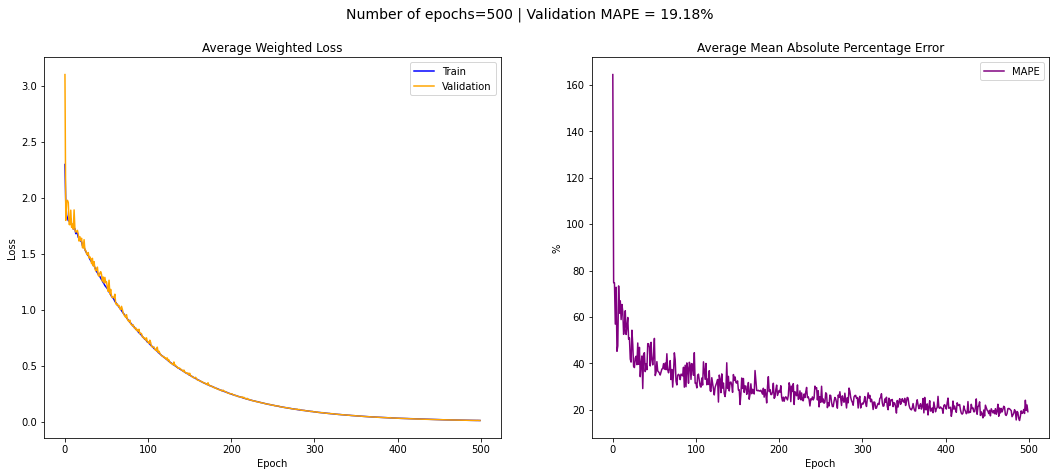

In [30]:
training_plot_summary(results); 

#### Backtest

**Training set**

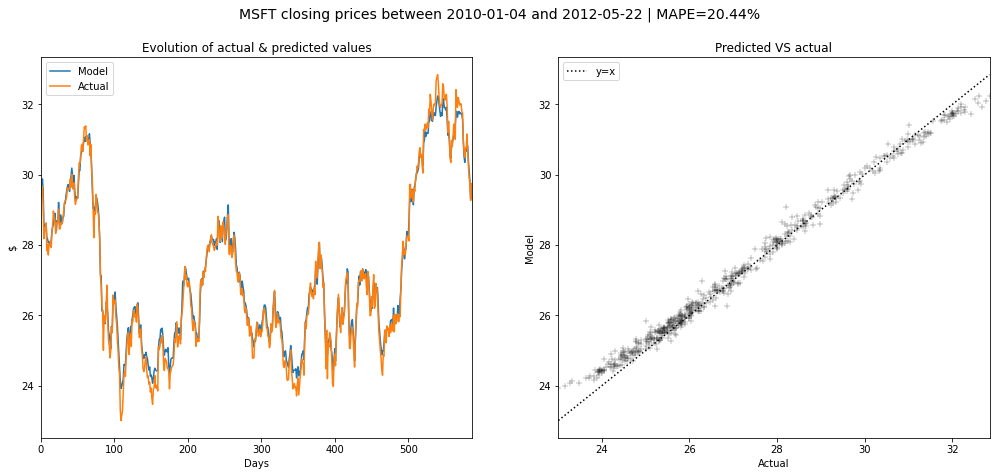

In [31]:
df_backtest, mape = create_backtest_dataset(model, data, training=True)
backtest_plot(ticker, df_backtest, mape, data.train_period)

**Test set** 

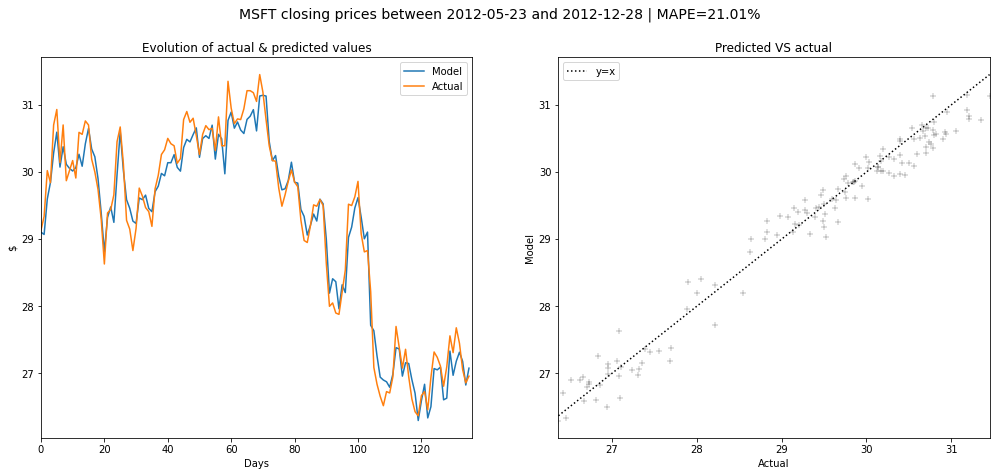

In [32]:
df_backtest, mape = create_backtest_dataset(model, data, training=False)
backtest_plot(ticker, df_backtest, mape, data.test_period)